In [66]:
import sqlite3
import pandas as pd
conn = sqlite3.connect("factbook.db")
cursor = conn.cursor()

q1 = "SELECT * FROM sqlite_master WHERE type='table';"
cursor.execute(q1)
cursor.fetchall()

[('table',
  'facts',
  'facts',
  2,
  'CREATE TABLE "facts" ("id" INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL, "code" varchar(255) NOT NULL, "name" varchar(255) NOT NULL, "area" integer, "area_land" integer, "area_water" integer, "population" integer, "population_growth" float, "birth_rate" float, "death_rate" float, "migration_rate" float, "created_at" datetime, "updated_at" datetime)'),
 ('table',
  'sqlite_sequence',
  'sqlite_sequence',
  3,
  'CREATE TABLE sqlite_sequence(name,seq)')]

In [67]:
database = pd.read_sql_query(q1, conn)
database

,type,name,tbl_name,rootpage,sql
0,table,facts,facts,2,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."
1,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"


In [68]:
q2 = "SELECT * FROM facts"
data = pd.read_sql_query(q2, conn)
data.head()

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
0,1,af,Afghanistan,652230.0,652230.0,0.0,32564342.0,2.32,38.57,13.89,1.51,2015-11-01 13:19:49.461734,2015-11-01 13:19:49.461734
1,2,al,Albania,28748.0,27398.0,1350.0,3029278.0,0.30,12.92,6.58,3.30,2015-11-01 13:19:54.431082,2015-11-01 13:19:54.431082
2,3,ag,Algeria,2381741.0,2381741.0,0.0,39542166.0,1.84,23.67,4.31,0.92,2015-11-01 13:19:59.961286,2015-11-01 13:19:59.961286
3,4,an,Andorra,468.0,468.0,0.0,85580.0,0.12,8.13,6.96,0.00,2015-11-01 13:20:03.659945,2015-11-01 13:20:03.659945
4,5,ao,Angola,1246700.0,1246700.0,0.0,19625353.0,2.78,38.78,11.49,0.46,2015-11-01 13:20:08.625072,2015-11-01 13:20:08.625072


In [69]:
q3 = "SELECT MIN(population), MAX(population), MIN(population_growth), MAX(population_growth) FROM facts"
data = pd.read_sql_query(q3, conn)
data.head()

,MIN(population),MAX(population),MIN(population_growth),MAX(population_growth)
0,0,7256490011,0.0,4.02


In [70]:
q4 = '''
SELECT * FROM facts 
WHERE population == (SELECT MIN(population) from facts);
'''
data = pd.read_sql_query(q4, conn)
data.head()

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
0,250,ay,Antarctica,None,280000,None,0,None,None,None,None,2015-11-01 13:38:44.885746,2015-11-01 13:38:44.885746


In [71]:
q5 = '''
SELECT * FROM facts 
WHERE population == (SELECT MAX(population) from facts);
'''
data = pd.read_sql_query(q5, conn)
data.head()

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
0,261,xx,World,None,None,None,7256490011,1.08,18.6,7.8,None,2015-11-01 13:39:09.910721,2015-11-01 13:39:09.910721


No one lives in Antarctica, and the highest population is the World.

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

q6 = '''
SELECT population, population_growth, birth_rate, death_rate
FROM facts
WHERE population != (SELECT MIN(population) from facts)
AND population != (SELECT MAX(population) from facts)
'''

data = pd.read_sql_query(q6, conn)
data

,population,population_growth,birth_rate,death_rate
0,32564342,2.32,38.57,13.89
1,3029278,0.30,12.92,6.58
2,39542166,1.84,23.67,4.31
3,85580,0.12,8.13,6.96
4,19625353,2.78,38.78,11.49
5,92436,1.24,15.85,5.69
6,43431886,0.93,16.64,7.33
7,3056382,0.15,13.61,9.34
8,22751014,1.07,12.15,7.14
9,8665550,0.55,9.41,9.42


/dataquest/system/env/python3/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2885: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


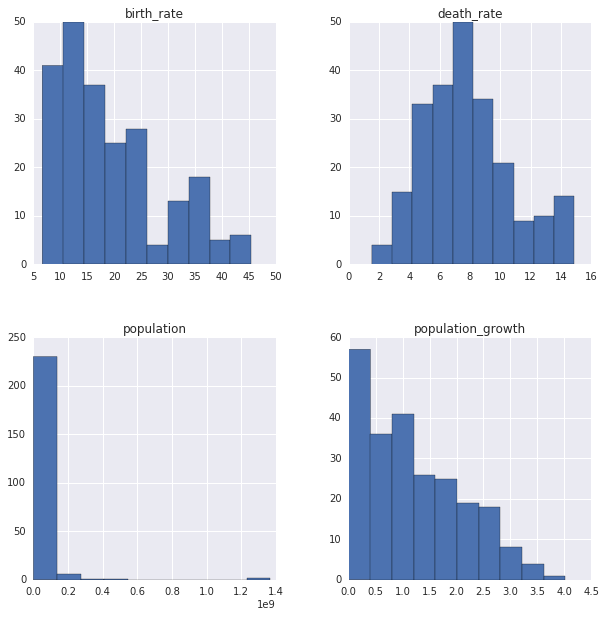

In [73]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

data.hist(ax=ax)
plt.show()

In [74]:
#highest density
q7 = '''
SELECT name, CAST(population as float)/CAST(area as float) "density"
FROM facts
WHERE population != (SELECT MIN(population) from facts)
AND population != (SELECT MAX(population) from facts)
ORDER BY density DESC
'''

data = pd.read_sql_query(q7, conn)
data

,name,density
0,Macau,21168.964286
1,Monaco,15267.500000
2,Singapore,8141.279770
3,Hong Kong,6445.041516
4,Gaza Strip,5191.819444
5,Gibraltar,4876.333333
6,Bahrain,1771.859211
7,Maldives,1319.640940
8,Malta,1310.015823
9,Bermuda,1299.925926


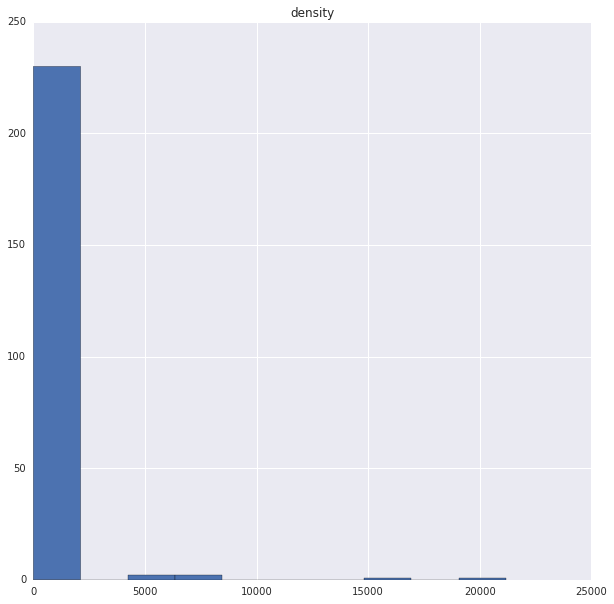

In [75]:

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

data.hist(ax=ax)
plt.show()